In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

texts = [
    " he is a good boy " ,
    " cricket is perfect " ,
    " the movie is fantastic" , 
    " seen a bad boy",
    " the movie is worst",
    " the movie is ugly",
]

labels = [1 , 1 , 1 , 0 , 0 , 0]

positive_concepts = ["fantastic" , " perfect" , " good" ]
negative_concepts = ["bad" , "worst" , "ugly"]

test_texts =[
    " cricket is fantastic ",
    " movie is ugly " ,
    " seen a good boy" , 
]

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(texts)

model = LogisticRegression()
model.fit(X_train , labels)

def get_concept_vectors(concepts):
    vectors = vectorizer.transform(concepts).toarray()
    return np.mean(vectors , axis =0)

def get_tcav_score(texts , concept_vec):
    vectors = vectorizer.transform(texts).toarray()
    scores = vectors@concept_vec
    predictions = model.predict(vectors)

    class1_score = np.mean(scores[predictions ==1])
    class0_score = np.mean(scores[predictions ==0])
    return class1_score -class0_score

positive_concept_vectors = get_concept_vectors(positive_concepts)
negative_concept_vectors = get_concept_vectors(negative_concepts)

print(" POSITIVE CONCEPT VECTORS :" , get_tcav_score(test_texts , positive_concept_vectors))
print(" NEGATIVE CONCEPT VECTORS :" , get_tcav_score(test_texts , negative_concept_vectors))


 POSITIVE CONCEPT VECTORS : 0.21275635636435192
 NEGATIVE CONCEPT VECTORS : -0.2525705431516785


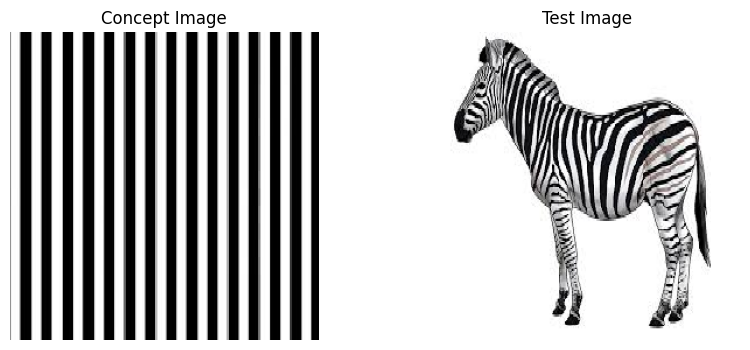

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


E:\Xai_Req_Setup\Python3109\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_7']
Received: inputs=Tensor(shape=(1, 264, 264, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


E:\Xai_Req_Setup\Python3109\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_7']
Received: inputs=Tensor(shape=(None, 264, 264, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Directional Derivative: -61966.8438
TCAV Score: 1.00


In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 1. Minimal CNN model
def build_model():
    inputs = Input(shape=(264, 264, 3))
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(32, (3, 3), activation='relu', name='target_layer')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    outputs = Dense(10, activation='softmax')(x)
    return Model(inputs, outputs)

model = build_model()
intermediate_model = Model([model.input], [model.get_layer('target_layer').output])

# 2. Load concept images (replace synthetic data generation)
def load_concept_images(concept_image_paths):
    concept_images = []
    for img_path in concept_image_paths:
        img = load_img(img_path, target_size=(264, 264))
        img_array = img_to_array(img) / 255.0  # Normalize the images
        concept_images.append(img_array)
    return np.array(concept_images)

# Example: Replace with paths to your concept images
concept_image_paths = ["stripes.jpeg"]
stripes = load_concept_images(concept_image_paths)

# Random negative examples (same as before)
random_images = np.random.rand(20, 264, 264, 3)  # Negative examples

# 3. Display sample images
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(stripes[0])
plt.title("Concept Image")
plt.axis('off')

plt.subplot(122)
# Replace the sample_image with your own test image
sample_image = img_to_array(load_img("zebra.jpeg", target_size=(264, 264)))/255.0
plt.imshow(sample_image)
plt.title("Test Image")
plt.axis('off')
plt.show()

# 4. Get activations
activations_stripes = intermediate_model.predict(stripes)
activations_random = intermediate_model.predict(random_images)

# 5. Train CAV
X = np.vstack([activations_stripes.reshape(len(stripes), -1), activations_random.reshape(20, -1)])
y = np.array([1]*len(stripes) + [0]*20)  # Adjusted to the length of the concept images

cav = SGDClassifier().fit(X, y).coef_

# 6. Calculate scores
sample_act = intermediate_model.predict(sample_image[np.newaxis, ...]).reshape(-1)
dd = np.dot(sample_act, cav.T)[0]
tcav = (np.dot(activations_stripes.reshape(len(stripes), -1), cav.T) > 0).mean()

print(f"Directional Derivative: {dd:.4f}\nTCAV Score: {tcav:.2f}")